Accessing CEFI Cloud data with Python
===

## Packages used
To use python to access the ERDDAP server directly from your python script or jupyter-notebook, you will need
- Xarray
- cf_xarray
- netcdf4 
- matplotlib
- zarr
- fsspec
- s3sf
- cartopy 

:::{admonition} Packages
The package [**netcdf4**](http://unidata.github.io/netcdf4-python/) developed by UNIDATA and the zarr engine are used at runtime. It is the essential package that [support netCDF format output from Xarray and OPeNDAP access](https://docs.xarray.dev/en/stable/user-guide/io.html) be available in the environment when using xarray. The package [**cartopy**](https://scitools.org.uk/cartopy/docs/latest/) is also not needed to read the data, but is used later in the script for making the map plots. 
:::

---

On this page, we will explore the process of extracting a subset of model simualtion data produce from the regional MOM6 model. The model output is to support the Climate Ecosystem and Fishery Initiative. We will showcase how to utilize xarray and fsspec for accessing the data and visualize it on an detailed map. The currently available data can be viewed on 
- [AWS](https://noaa-oar-cefi-regional-mom6-pds.s3.amazonaws.com/index.html)
- [Google Cloud Storage](https://console.cloud.google.com/storage/browser/noaa-oar-cefi-regional-mom6)

The contents of this folder encompass hindcast simulations derived from the regional MOM6 model spanning the years 1993 to 2019.

## Import python packages

In [1]:
import xarray as xr
import cf_xarray # This is a wrapper for xarray that allows access to the data through standard coordinate names
import fsspec

:::{admonition} Info
Thanks to the xarray, fsspec, zarr and kerchunk, accessing data from the cloud directly from Xarray is seamless. For detailed usage guidance, the [Xarray documentation](https://docs.xarray.dev/en/stable/user-guide/io.html#cloud-storage-buckets) offers excellent examples and explanations.
:::

## Access data (regular grid product)

From the previous page explaining [OPeNDAP interface](opendapData), we know that the OPeNDAP URL can be obtained from the form. In our case, we will use the browser to find the name of the object we want from the links to the cloud storage. The object names follow the same directory pattern as the OPeNDAP data on the portal.

In [2]:
fs = fsspec.filesystem(
    "reference", 
    fo='gcs://noaa-oar-cefi-regional-mom6/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/tob.nwa.full.hcast.monthly.regrid.r20230520.199301-201912.json', 
    remote_protocol="gcs", 
    remote_options={"anon":True},
    skip_instance_cache=True,
    target_options={"anon": True}
)
m = fs.get_mapper()
ds_tob = xr.open_dataset(m, engine='zarr', consolidated=False)

:::{admonition} Info
`fsspec` is a library that provides a unified interface for accessing various file systems, including local, cloud, and remote file systems. filesystem("reference", ...) creates a reference file system using fsspec. This is used to access a dataset described by a reference JSON file.

`get_mapper` method returns a mapper object that can be used to access the data described by the reference JSON file.

Finally, we use the `xr.open_dataset` to open the remote dataset using the zarr engine.
:::

In [3]:
ds_tob.cf

Coordinates:
             CF Axes: * X: ['lon']
                      * Y: ['lat']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['lon']
                      * latitude: ['lat']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names: * latitude: ['lat']
                      * longitude: ['lon']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   sea_water_potential_temperature_at_sea_floor: ['tob']

              Bounds:   n/a

       Grid Mappings:   n/a

In [4]:
ds_tob

<xarray.Dataset> Size: 847MB
Dimensions:  (lat: 844, lon: 774, time: 324)
Coordinates:
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T12:...
Data variables:
    tob      (time, lat, lon) float32 847MB ...
Attributes: (12/30)
    NCO:                    netCDF Operators version 5.0.1 (Homepage = http:/...
    NumFilesInSet:          1
    associated_files:       areacello: 19930101.ocean_static.nc
    cefi_archive_version:   /archive/acr/fre/NWA/2023_04/NWA12_COBALT_2023_04...
    cefi_aux:               N/A
    cefi_data_doi:          10.5281/zenodo.7893386
    ...                     ...
    contact:                chia-wei.hsu@noaa.gov
    dataset:                regional mom6 regrid
    external_variables:     areacello
    grid_tile:              N/A
    grid_type:              regular
    title:                  NWA12_COBALT_2023_04_kpo4-coastatten-physics

:::{admonition} Tip
:class: tip
When we use `xr.open_dataset()` to load the data, we actually only load the metadata and coordinates information. This provide a great way to peek at the data’s dimension and availability on our local machine in the xarray object format. The actual gridded data values at each grid point will only be downloaded from the cloud server when we add `.load()` to the dataset or when we access the data with a visualization or analysis operation. 
:::

xarray will lazy load the data from the selected subset when it's needed, in this case when the plot is made below. 

In [5]:
ds_tob_subset = ds_tob.sel(time='2012-12')

In [6]:
ds_tob_subset

<xarray.Dataset> Size: 3MB
Dimensions:  (lat: 844, lon: 774, time: 1)
Coordinates:
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
  * time     (time) datetime64[ns] 8B 2012-12-16T12:00:00
Data variables:
    tob      (time, lat, lon) float32 3MB ...
Attributes: (12/30)
    NCO:                    netCDF Operators version 5.0.1 (Homepage = http:/...
    NumFilesInSet:          1
    associated_files:       areacello: 19930101.ocean_static.nc
    cefi_archive_version:   /archive/acr/fre/NWA/2023_04/NWA12_COBALT_2023_04...
    cefi_aux:               N/A
    cefi_data_doi:          10.5281/zenodo.7893386
    ...                     ...
    contact:                chia-wei.hsu@noaa.gov
    dataset:                regional mom6 regrid
    external_variables:     areacello
    grid_tile:              N/A
    grid_type:              regular
    title:                  NWA12_COBALT_2023_04_kpo4-coastatten-physics

## Quick view of the variable

To check if the data makes sense and fits the chosen time and region, you can use Xarray's `.plot()` method. This way, you see a graph, making it easier to understand.

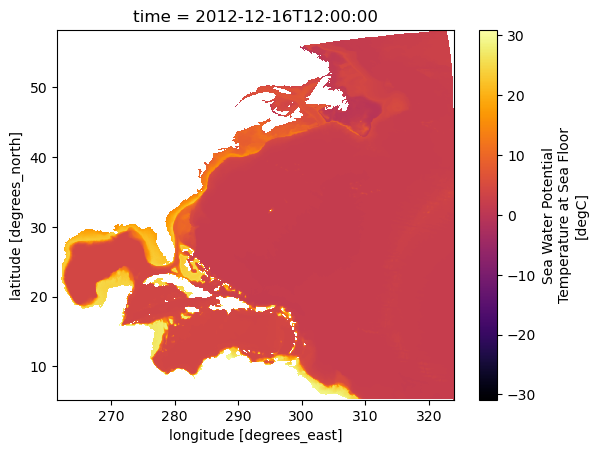

In [7]:
ds_tob_subset.tob.plot(cmap='inferno')

## Plotting the data on a detailed map
In this section, we are going to use cartopy to plot the data with a detailed map backgournd. 

In [8]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

### Specify figure setup
 - Use the cf wrapper to reference the latitude, longitude and time via their CF standard names.
 - Calculate the aspect ratio of the data to set the aspect ratio of the figure
 - Shows how to center the plot at 180, not applicable to this data set, but critical for others like the NE Pacific.

In [9]:
xmin = ds_tob_subset.cf['longitude'].min()
xmax = ds_tob_subset.cf['longitude'].max()
ymin = ds_tob_subset.cf['latitude'].min()
ymax = ds_tob_subset.cf['latitude'].max()
aspect = (xmax-xmin)/(ymax-ymin)

### Add details to the map
 - Use the default land feature to fill in the land mass
 - Draw the coasts with the 50m data (will trigger a download of the data the first time you use it).
 - Draw some graticules
 - Put the colorbar on top and size it to fit the plot
 - Create a title from the metadata in the file and the variable name
 - Draw the plot

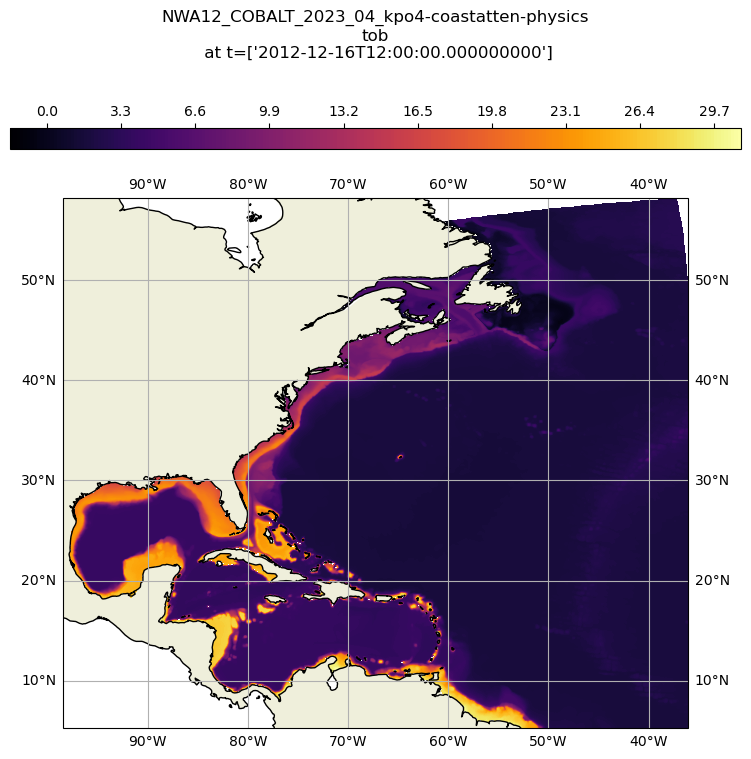

In [10]:
plt.figure(figsize=(8*aspect,8))
proj = ccrs.PlateCarree(central_longitude=180)
proj180 = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], crs=proj180)
# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.coastlines('50m')
gl = ax.gridlines(draw_labels=True)
ct = ax.contourf(ds_tob_subset.cf['longitude'], ds_tob_subset.cf['latitude'], ds_tob_subset['tob'][0], levels=255, transform=proj180, cmap="inferno")
plt.colorbar(ct, orientation='horizontal',pad=0.08, aspect=35, fraction=.06, location='top')
plt.title(str(ds_tob_subset.attrs['title']) + '\ntob\n at t=' + str(ds_tob_subset['time'].values), y=1.25)
plt.show()

## Access data (raw grid product) 

The raw grid product differs from the regular grid in that it represents the original output of the model. The model grid uses the Arakawa C grid. The [Regional MOM6 Grid](rmom6Grid) provides an excellent visualization of the Arakawa C grid. We can concentrate on the `h` point, which is where scalar values like sea level height are stored. The grid does not have uniform spacing and is, in fact, a curvilinear grid.

:::{admonition} Info
The raw model output is beneficial when calculating the energy budget, which includes factors like heat and momentum. This output preserves each term's original values, avoiding any potential distortions caused by interpolation. By using the raw grid product, we can ensure the energy budget balances within a closed system.
:::


To use the raw grid data, one need to get two files. 
1. the variable file
2. the static file

For this demonstration we will use the AWS S3 to access the data. You can use either the Google Cloud Storage copy (gcs://noaa-oar-cefi-regional-mom6) or the AWS copy (s3://noaa-oar-cefi-regional-mom6-pds) by changing the prefix and name of the bucket.

In [11]:
fs = fsspec.filesystem(
    "reference", 
    fo='s3://noaa-oar-cefi-regional-mom6-pds/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/tob.nwa.full.hcast.monthly.raw.r20230520.199301-201912.json',
    remote_protocol="s3", 
    remote_options={"anon":True},
    consolicated=False,
    skip_instance_cache=True,
    target_options={"anon": True}
)
map_s = fs.get_mapper()
ds_tob = xr.open_dataset(map_s, engine='zarr', consolidated=False)

fs_os = fsspec.filesystem(
    "reference", 
    fo='s3://noaa-oar-cefi-regional-mom6-pds/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/ocean_static.json',
    remote_protocol="s3", 
    remote_options={"anon":True},
    skip_instance_cache=True,
    target_options={"anon": True}
)
map_os = fs_os.get_mapper() 
ds_static = xr.open_dataset(map_os, engine='zarr', consolidated=False)

In [12]:
ds_tob

<xarray.Dataset> Size: 849MB
Dimensions:     (time: 324, nv: 2, yh: 845, xh: 775)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T...
  * xh          (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh          (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
Data variables:
    average_DT  (time) timedelta64[ns] 3kB ...
    average_T1  (time) datetime64[ns] 3kB ...
    average_T2  (time) datetime64[ns] 3kB ...
    time_bnds   (time, nv) datetime64[ns] 5kB ...
    tob         (time, yh, xh) float32 849MB ...
Attributes: (12/27)
    NCO:                    netCDF Operators version 5.0.1 (Homepage = http:/...
    NumFilesInSet:          1
    associated_files:       areacello: 19930101.ocean_static.nc
    cefi_archive_version:   /archive/acr/fre/NWA/2023_04/NWA12_COBALT_2023_04...
    cefi_aux:               N/A
    cefi_data_doi:          10.5281/zenodo.7893386
    ...                     ...
    cefi_subdomain:         full
    cefi_variable:          tob
    external_variables:     areacello
    grid_tile:              N/A
    grid_type:              regular
    title:                  NWA12_COBALT_2023_04_kpo4-coastatten-physics

In [13]:
ds_static

<xarray.Dataset> Size: 66MB
Dimensions:       (yq: 846, xq: 776, yh: 845, xh: 775, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 8B 1980-01-01
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
Data variables: (12/25)
    Coriolis      (yq, xq) float32 3MB ...
    areacello     (yh, xh) float32 3MB ...
    areacello_bu  (yq, xq) float32 3MB ...
    areacello_cu  (yh, xq) float32 3MB ...
    areacello_cv  (yq, xh) float32 3MB ...
    deptho        (yh, xh) float32 3MB ...
    ...            ...
    geolon_v      (yq, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    wet_u         (yh, xq) float32 3MB ...
    wet_v         (yq, xh) float32 3MB ...
Attributes:
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....
    NumFilesInSet:  1
    grid_tile:      N/A
    grid_type:      regular
    history:        Fri May 12 10:50:21 2023: ncks -4 -L 3 ocean_static.nc co...
    title:          NWA12_MOM6_v1.0

:::{admonition} Tip
:class: tip
Again, only the metadata and coordinate information are loaded into local memory, not the actual data. The gridded data values at each grid point are only downloaded from the cloud when we append `.load()` to the dataset.
:::



:::{admonition} Warning
:class: tip
In the `ds_static` dataset, you can observe the one-dimensional `xh, yh` grid. The numbers on this grid may resemble longitude and latitude values, but they do not represent actual geographical locations. For accurate longitude and latitude data, you should refer to the `geolon, geolat` variables in the list. These variables, which are dimensioned by `xh, yh`, provide the correct geographical coordinates.
:::

Now let's take a look at the grid area distribution which give a great sense of how it is different from regular spacing grid

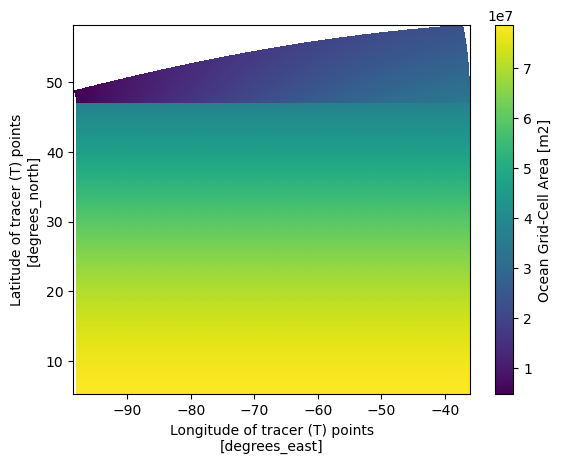

In [14]:
ds_static = ds_static.set_coords(['geolon','geolat'])
ds_static.areacello.plot(x='geolon',y='geolat')

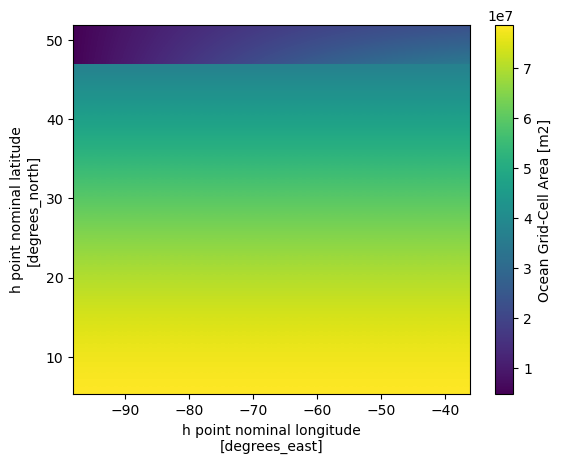

In [15]:
ds_static.areacello.plot(x='xh',y='yh')

We can see that the most significant differences between the two maps are located in the higher latitudes. Since the grid information is important in the raw grid, the easiest way to merge the two dataset so we can have the accurate lon lat that follows the data that we are going to work on.

In [16]:
ds_tob_subset = ds_tob.sel(time='2012-12').load()
ds = xr.merge([ds_tob_subset,ds_static])
ds = ds.isel(time=slice(1,None))  # exclude the 1980 empty field due to merge

From the xarray dataset object output above, we will notice the `tob` value in `ds` is now avaible and the coordinate information in the coordinate is also included into a single Dataset object.
In the line below, we'll assign the latitude and longitude names to geolat and geolon to help the CF library identify them since the data lacks the proper attributes for this to happen automatically.

In [17]:
ds = ds.assign_coords(latitude=ds.geolat, longitude=ds.geolon)

In [18]:
ds.cf

Coordinates:
             CF Axes: * X: ['xh', 'xq']
                      * Y: ['yh', 'yq']
                      * T: ['time']
                        Z: n/a

      CF Coordinates:   longitude: ['geolon', 'longitude', 'xh', 'xq']
                        latitude: ['geolat', 'latitude', 'yh', 'yq']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area: ['areacello']
                        volume: n/a

      Standard Names:   SeaAreaFraction: ['sftof']
                        cell_area: ['areacello', 'areacello_bu', 'areacello_cu', 'areacello_cv']
                        sea_floor_depth_below_geoid: ['deptho']
                        sea_water_potential_temperature_at_sea_floor: ['tob']

              Bounds:   T: ['time_bnds']
                        time: ['time_bnds']

       Grid Mappi

## Quick view of the variable

To check if the data makes sense and fits the chosen time and region, you can use Xarray's `.plot()` method. This way, you see a graph instead of just numbers, making it easier to understand.

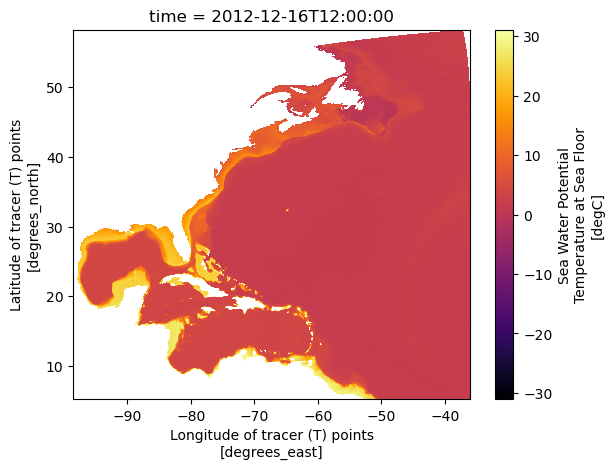

In [19]:
ds.tob.plot(x='longitude',y='latitude', cmap='inferno')

## Make a detailed plot showing the underlying grid

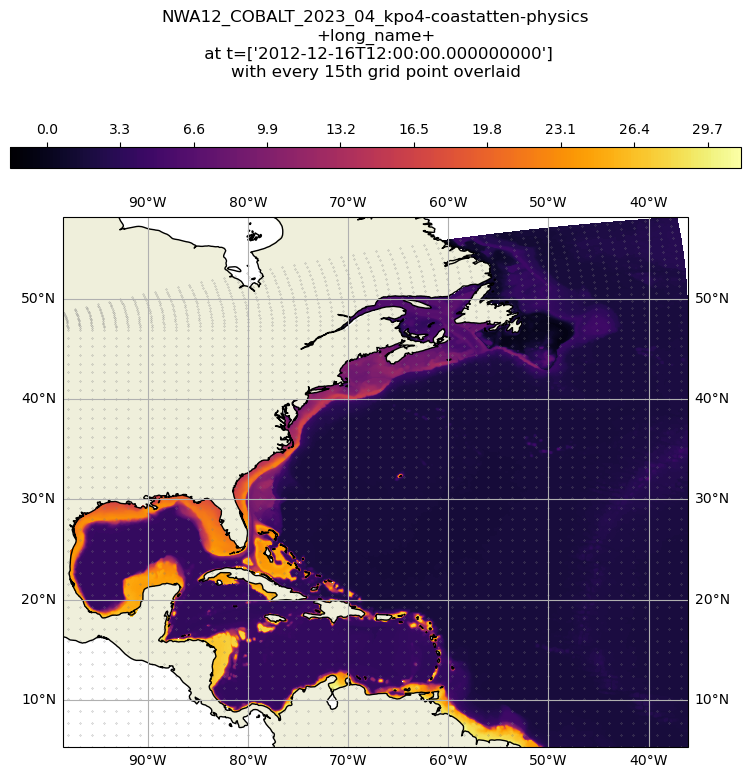

In [21]:
long_name = ds.tob.attrs['long_name']
xmin = ds['longitude'].min()
xmax = ds['longitude'].max()
ymin = ds['latitude'].min()
ymax = ds['latitude'].max()
aspect = (xmax-xmin)/(ymax-ymin)
plt.figure(figsize=(8*aspect,8))
proj = ccrs.PlateCarree(central_longitude=180)
proj180 = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], crs=proj180)
# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
ax.coastlines('50m')
gl = ax.gridlines(draw_labels=True)
ct = ax.contourf(ds['longitude'], ds['latitude'], ds['tob'][0], levels=255, transform=proj180, cmap="inferno")
plt.colorbar(ct, orientation='horizontal',pad=0.08, aspect=35, fraction=.06, location='top', cmap="inferno")
ax.autoscale(False) # keep the scalling info the same for the grid dots
ct = ax.scatter(ds['longitude'][::15,::15], ds['latitude'][::15,::15], .05, zorder=1, transform=proj180, color='grey')
plt.title(str(ds.attrs['title']) + '\n+long_name+\n at t=' + str(ds['time'].values)+'\nwith every 15th grid point overlaid', y=1.25)
plt.show()